In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random

In [2]:
# this is code implements the Viterbi algorithm to find the optimal state paths

def viterbi(transition, start_probs, emission, hnd_dat):
    
    M = transition.shape[0]
    
    states = [i + 1 for i in range(M)]
    sequence_syms = {'R':0,'P':1,'S':2}
    sequence = ['R','S','P']

    N = len(hnd_dat)

    Y = hnd_dat['0']

    X = hnd_dat['1']

    pi, b, a = start_probs, emission, transition

    # Initialize D and E matrices
    D = np.zeros((M, N))
    E = np.zeros((M, N-1)).astype(np.int32)
    D[:, 0] = np.multiply(pi, b[X[0]-1][:, Y[0]-1])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(M):

            temp_product = np.multiply(a[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * b[X[n]-1][i, Y[n]-1]
            E[i, n-1] = np.argmax(temp_product)

            #break

        #break

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]
        
    return S_opt


In [3]:
# this is EM learning algorithm to infer the parameters 
# it returns the initial probability; transition probability; emission probability and posterior probability of states

def run_em(hnd_dat=[], M=2, iteration=100, start_probs=[], initial_probs=[], transition=[], emission=[]):
    
    #generating initial probabilities
    states = [i + 1 for i in range(M)]
    sequence_syms = {'R':0,'P':1,'S':2}
    sequence = ['R','S','P']

    if len(transition) == 0:
        
        #transition probabilities
        np.random.seed(111)
        A = np.random.random((len(states), len(states)))
        transition = np.array([A[i] / sum(A[i]) for i in range(len(states))])

    if len(emission) == 0:
        #Emission probabilities
        emission = np.zeros((len(states), len(sequence), len(sequence)))
        
        # normalize such that the row sum is 1
                            
        for i in range(len(states)):
            
            np.random.seed(111)

            A = np.random.random((len(sequence), len(sequence)))
        
            emission[i] = np.array([A[i] / sum(A[i]) for i in range(len(sequence))])
        

    #probabilities of going to end state
    end_probs = [1 for _ in range(len(states))]
    
    if len(start_probs) == 0:
        #probabilities of going from start state
        start_probs = [1.0/len(states) for _ in range(len(states))]
    
    if len(initial_probs) == 0:
        
        #probability of AI in first game
        initial_probs = [1.0/3, 1.0/3, 1.0/3]

    #test sequence
    
    if len(hnd_dat) == 0:
        
        test_sequence = 'PPRSPPSSP'
        ai_sequence = 'PPPSPSSPR'

    else:
        
        test_sequence = "".join(hnd_dat["0"].replace(1, "R").replace(2, "P").replace(3, "S").to_list())
        
        ai_sequence = "".join(hnd_dat["1"].replace(1, "R").replace(2, "P").replace(3, "S").to_list())
        
    
    def likelihood():
        
        # node values stored during forward algorithm
        node_values_likelihood = np.zeros((len(states), len(test_sequence)))
        
        for i, sequence_val in enumerate(test_sequence):

            xnow, ynow = ai_sequence[i], test_sequence[i]

            # if first sequence value then do this
            if (i == 0):
                node_values_likelihood[j, i] = start_probs[j]
            # else perform this
            else:

                x_last, y_last = ai_sequence[i-1], test_sequence[i-1]
                
                e = np.zeros((len(states), len(sequence)))

                # rule 1 P(DSU|WTL)

                # P(RPS) prior
                e[0] = np.array([1/3, 1/3, 1/3])

                # W case: 
                if (y_last == "P" and x_last == "R") | (y_last == "S" and x_last == "P") | (y_last == "R" and x_last == "S"):

                    # P(DSU|W)
                    p = emission[0][0]

                # T case: 
                if y_last == x_last:

                    # P(DSU|T)
                    p = emission[0][1]

                # L case:
                if (y_last == "R" and x_last == "P") | (y_last == "P" and x_last == "S") | (y_last == "S" and x_last == "R"):

                    # P(DSU|L)
                    p = emission[0][2]


                if y_last == "R":

                    # D --> Sissor, S --> Rock, U --> Paper

                    e[0] = np.array([p[1], p[2], p[0]])

                if y_last == "P":

                    # D --> Rock, S --> Paper, U --> Sissor

                    e[0] = np.array([p[0], p[1], p[2]])

                if y_last == "S":

                    # D --> Paper, S --> Sissor, U --> Rock

                    e[0] = np.array([p[2], p[0], p[1]])

                # rule 2 P(RPS|RPS)
                # P(RPS) prior
                e[1] = np.array([1/3, 1/3, 1/3]) 

                p = emission[1][sequence_syms[y_last]]

                e[1] = p


                node_values_likelihood[0, i] = e[0][sequence_syms[ynow]] / (e[0][sequence_syms[ynow]] + e[1][sequence_syms[ynow]])
                
                node_values_likelihood[1, i] = e[1][sequence_syms[ynow]] / (e[0][sequence_syms[ynow]] + e[1][sequence_syms[ynow]])

        return node_values_likelihood



    #function to find forward probabilities
    def forward_probs():
        # node values stored during forward algorithm
        node_values_fwd = np.zeros((len(states), len(test_sequence)))

        for i, sequence_val in enumerate(test_sequence):

            xnow, ynow = ai_sequence[i], test_sequence[i]

            for j in range(len(states)):
                # if first sequence value then do this
                if (i == 0):
                    node_values_fwd[j, i] = start_probs[j]
                # else perform this
                else:

                    x_last, y_last = ai_sequence[i-1], test_sequence[i-1]

                    # rule 1 P(DSU|WTL)
                    if j == 0:
                        
                        # P(RPS) prior
                        e = np.array([1/3, 1/3, 1/3])
                            
                        # W case: 
                        if (y_last == "P" and x_last == "R") | (y_last == "S" and x_last == "P") | (y_last == "R" and x_last == "S"):
                            
                            # P(DSU|W)
                            p = emission[0][0]
                            
                        # T case: 
                        if y_last == x_last:
                            
                            # P(DSU|T)
                            p = emission[0][1]
                            
                        # L case:
                        if (y_last == "R" and x_last == "P") | (y_last == "P" and x_last == "S") | (y_last == "S" and x_last == "R"):
                            
                            # P(DSU|L)
                            p = emission[0][2]
                        
                             
                        if y_last == "R":

                            # D --> Sissor, S --> Rock, U --> Paper

                            e = np.array([p[1], p[2], p[0]])

                        if y_last == "P":

                            # D --> Rock, S --> Paper, U --> Sissor

                            e = np.array([p[0], p[1], p[2]])

                        if y_last == "S":

                            # D --> Paper, S --> Sissor, U --> Rock

                            e = np.array([p[2], p[0], p[1]])
                            
                    # rule 2 P(RPS|RPS)
                    if j == 1:
                            
                        # P(RPS) prior
                        e = np.array([1/3, 1/3, 1/3]) 
                               
                        p = emission[1][sequence_syms[y_last]]
                            
                        e = p
                                                
                    values = [node_values_fwd[k, i - 1] * e[sequence_syms[ynow]] * transition[k, j] for k in range(len(states))]

                    node_values_fwd[j, i] = sum(values)

        return node_values_fwd



    #function to find backward probabilities
    def backward_probs():
        # node values stored during forward algorithm
        node_values_bwd = np.zeros((len(states), len(test_sequence)))

        #for i, sequence_val in enumerate(test_sequence):
        for i in range(1,len(test_sequence)+1):
            for j in range(len(states)):
                # if first sequence value then do this
                if (-i == -1):
                    node_values_bwd[j, -i] = end_probs[j]
                # else perform this
                else:
                    x_last, y_last = ai_sequence[-i], test_sequence[-i]

                    xnow, ynow = ai_sequence[-i+1], test_sequence[-i+1]
                            
                    e = np.zeros((len(states), len(sequence)))
                                   
                    # rule 1 P(DSU|WTL)
                    
                    # P(RPS) prior
                    e[0] = np.array([1/3, 1/3, 1/3])

                    # W case: 
                    if (y_last == "P" and x_last == "R") | (y_last == "S" and x_last == "P") | (y_last == "R" and x_last == "S"):

                        # P(DSU|W)
                        p = emission[0][0]

                    # T case: 
                    if y_last == x_last:

                        # P(DSU|T)
                        p = emission[0][1]

                    # L case:
                    if (y_last == "R" and x_last == "P") | (y_last == "P" and x_last == "S") | (y_last == "S" and x_last == "R"):

                        # P(DSU|L)
                        p = emission[0][2]


                    if y_last == "R":

                        # D --> Sissor, S --> Rock, U --> Paper

                        e[0] = np.array([p[1], p[2], p[0]])

                    if y_last == "P":

                        # D --> Rock, S --> Paper, U --> Sissor

                        e[0] = np.array([p[0], p[1], p[2]])

                    if y_last == "S":

                        # D --> Paper, S --> Sissor, U --> Rock

                        e[0] = np.array([p[2], p[0], p[1]])
                            
                    # rule 2 P(RPS|RPS)
                            
                    # P(RPS) prior
                    e[1] = np.array([1/3, 1/3, 1/3]) 

                    p = emission[1][sequence_syms[y_last]]

                    e[1] = p

                    values = [node_values_bwd[k, -i+1] * e[k][sequence_syms[ynow]] * transition[j, k] for k in range(len(states))]

                    node_values_bwd[j, -i] = sum(values)

        return node_values_bwd


    #function to find si probabilities
    def si_probs(forward, backward):

        si_probabilities = np.zeros((len(states), len(test_sequence)-1, len(states)))

        for j in range(len(states)):
            forward_val = sum(np.multiply(forward[j, :], backward[j, :]))
            for t in range(len(test_sequence)-1):
                for k in range(len(states)):

                    xnow, ynow = ai_sequence[t+1], test_sequence[t+1]

                    x_last, y_last = ai_sequence[t], test_sequence[t]
                            
                            
                    # rule 1 P(DSU|WTL)
                    if k == 0:
                        
                        # P(RPS) prior
                        e = np.array([1/3, 1/3, 1/3])
                            
                        # W case: 
                        if (y_last == "P" and x_last == "R") | (y_last == "S" and x_last == "P") | (y_last == "R" and x_last == "S"):

                            # P(DSU|W)
                            p = emission[0][0]

                        # T case: 
                        if y_last == x_last:

                            # P(DSU|T)
                            p = emission[0][1]

                        # L case:
                        if (y_last == "R" and x_last == "P") | (y_last == "P" and x_last == "S") | (y_last == "S" and x_last == "R"):

                            # P(DSU|L)
                            p = emission[0][2]

                             
                        if y_last == "R":

                            # D --> Sissor, S --> Rock, U --> Paper

                            e = np.array([p[1], p[2], p[0]])

                        if y_last == "P":

                            # D --> Rock, S --> Paper, U --> Sissor

                            e = np.array([p[0], p[1], p[2]])

                        if y_last == "S":

                            # D --> Paper, S --> Sissor, U --> Rock

                            e = np.array([p[2], p[0], p[1]])
                            
                    # rule 2 P(RPS|RPS)
                    if k == 1:
                            
                        # P(RPS) prior
                        e = np.array([1/3, 1/3, 1/3]) 
                               
                        p =emission[1][sequence_syms[y_last]]
                            
                        e = p

                    if forward_val == 0:
                        si_probabilities[j,t,k] = 0
                    else:
                        si_probabilities[j,t,k] = sum([forward[j,t] * backward[k,t+1] * transition[j,k] * e[sequence_syms[ynow]]]) \
                                                        / forward_val
                        
                            
        return si_probabilities

    #function to find gamma probabilities
    def gamma_probs(forward, backward):

        gamma_probabilities = np.zeros((len(states), len(test_sequence)))     

        for i in range(len(states)):

            for t in range(len(test_sequence)):

                gamma_probabilities[i, t] = (forward[i, t] * backward[i, t])

        for t in range(len(test_sequence)):

            if sum(gamma_probabilities[:, t]) == 0:

                gamma_probabilities[:, t] = 0

            else:

                gamma_probabilities[:, t] = gamma_probabilities[:, t] / sum(gamma_probabilities[:, t])

        return gamma_probabilities

    ###################################
    ###################################
    
    for iteration in range(iteration):

        print('\nIteration No: ', iteration + 1)
        # print('\nTransition:\n ', transition)
        # print('\nEmission: \n', emission)

        #Calling probability functions to calculate all probabilities
        fwd_probs = forward_probs()
        bwd_probs = backward_probs()

        #end state value
        end_state_val = sum(fwd_probs[:, -1])


        si_probabilities = si_probs(fwd_probs, bwd_probs)
        gamma_probabilities = gamma_probs(fwd_probs, bwd_probs)

        print('Forward Probs:')
        print(np.matrix(fwd_probs)[:5, :5])
        #
        print('Backward Probs:')
        print(np.matrix(bwd_probs)[:5, :5])
        #
        '''print('Si Probs:')
        print(si_probabilities)'''
        #
        print('Gamma Probs:')
        print(np.matrix(gamma_probabilities)[:5, :5])

        #break

        #caclculating 'a' and 'b' matrices
        a = np.zeros((len(states), len(states)))
        #b = np.zeros((len(sequence), len(states), len(sequence)))


        #'a' matrix
        for j in range(len(states)):
            for i in range(len(states)):
                for t in range(len(test_sequence)-1):
                    a[j,i] = a[j,i] + si_probabilities[j,t,i]

                denomenator_a = [si_probabilities[j, t_x, i_x] for t_x in range(len(test_sequence) - 1) for i_x in range(len(states))]
                denomenator_a = sum(denomenator_a)

                if (denomenator_a == 0):
                    a[j,i] = 0
                else:
                    a[j,i] = a[j,i]/denomenator_a


        # 'pi' start probability
        start_probs = gamma_probabilities[:, 0] / sum(gamma_probabilities[:, 0])
        
        print('Initial Probs:')
        print(np.matrix(start_probs.round(decimals=4)))

        print('\nMatrix a:\n')
        print(np.matrix(a.round(decimals=12)))

        print('\nMatrix b:\n')
        #print(np.matrix(b[0].round(decimals=4)))
        #for i in range(len(sequence)):
            #print(np.matrix(b[i].round(decimals=4)))

        #transition = a
        #emission = b


        new_fwd_temp = forward_probs()
        new_end_state_val = sum(new_fwd_temp[:, -1])
        #print('Forward probability', end_state_val)
        #print('New forward probability: ', new_end_state_val, new_fwd_temp)
        diff =  np.abs(end_state_val - new_end_state_val)
        print('Difference in forward probability: ', diff)
        
    print(start_probs, end_probs, transition, emission)
    
    return start_probs, end_probs, transition, emission, gamma_probabilities, si_probabilities, fwd_probs, bwd_probs, likelihood()

### Simulate Ali's example, Ns is the number of games.

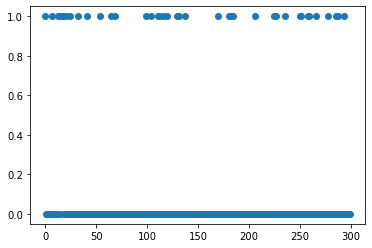

In [4]:
## simulate Ali's example
## This simulation is for two rules; P(DSU|WTL) (rule 1) and P(RPS|RPS) (rule 2)
## 1 represents R, 2 represents P, and 3 represnts S
## 1 means win, 3 means lose, and 2 mean tie
## S is 1 which is rule 1 and S is 2 for rule 2

# Simulation Lenght
# we need make this number big enough to make the empirical result under rule 2 close to the assumption
Ns  = 300


# State Transition Probabilty 
Ps   = [[0.9, 0.1],
        [0.9, 0.1]]

Ps_0 = [0.5, 0.5]

## Rule 1
## for instace,row 1 is win: stay has 0.8 probability
P1 = [[0.1, 0.8, 0.1],
      [1/3, 1/3, 1/3],
      [0.2, 0.1, 0.7]]

## Rule 2
## for instace,row 1 is R: the next hand is randomly drawn
P2 = [[1/3, 1/3, 1/3],
      [1/3, 1/3, 1/3],
      [1/3, 1/3, 1/3]]

##%% Create AI hand
AI = []
for i in range(Ns):
    AI.append(random.randint(0,2))

#plt.plot(pd.Series(AI), 'o')

##Create Swithc Trajectory (Hidden, but in simulation we create thus we know it)
SW = [0 for _ in range(Ns)]
SW[0]  = np.random.binomial(1, Ps_0[0], 1)[0]
for i in range(1, Ns):
        
    SW[i] = np.random.binomial(1, Ps[SW[i-1]][1], 1)[0]
    
plt.plot(pd.Series(SW),'o')


## We create participants hand; we also keep Game Outcome
WTL = [0 for _ in range(Ns)]
Y  = [0 for _ in range(Ns)]
y_last = 0  #% pick R as the last hand 
w_last = 1  #% pick tie as the last game outcome

for i in range(0, Ns):
    
    if SW[i] == 0:  #% rule 1 (D,S,U)
        
        temp = P1[w_last]
        
        rng = np.random.default_rng()
        r = rng.multinomial(1, temp, size=1)

        ty = np.where(r == 1)[1][0]
        
        if ty == 0:
                        
            ynow = y_last-1
           
            if ynow == -1:
                ynow = 2
                
        if ty == 1:
                                                    
            ynow = y_last
            
        
        if ty == 2:
                        
            ynow = y_last + 1
            
            if ynow == 3:
                
                ynow = 0
                
                
    else:            #% rule 2
        
        temp = P2[y_last]
        
        rng = np.random.default_rng()
        r = rng.multinomial(1, temp, size=1)

        ty = np.where(r == 1)[1][0]
        
        ynow = ty
        
        
    xnow = AI[i]
            
    if ynow == xnow:
    
        wnow = 1
        
    elif (ynow == 0 and xnow == 1) | (ynow == 1 and xnow == 2) | (ynow == 2 and xnow == 0):
        
        wnow = 2
        
    elif (ynow == 1 and xnow == 0) | (ynow == 2 and xnow == 1) | (ynow == 0 and xnow == 2):
        
        wnow = 0
        
    else:
        
        print("Error")
        
        break
   
    y_last = ynow
    
    w_last = wnow
    
    Y[i]   = ynow
    
    WTL[i]  = wnow
    
    
            


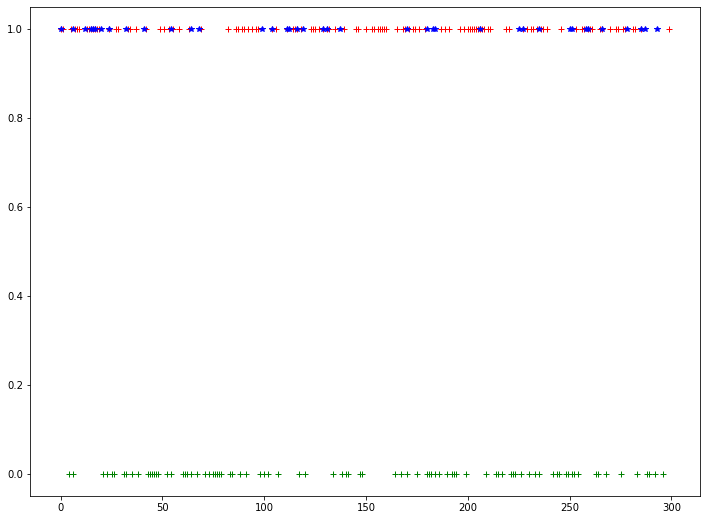

In [5]:
# save the simulation into pandas dataframe

df = pd.DataFrame({'0': Y, '1': AI, '2': WTL})

df['state'] = SW

hf = df.copy()


df['2'] = df['2'].map({0: 1, 1: 2, 2: 0})

plt.figure(figsize=(12, 9))

plt.plot(df[df['2'] == 1]['2'], 'r+')

plt.plot(df[df['2'] == 0]['2'], 'g+')

plt.plot(df[df['state'] == 1]['state'], 'b*')

#############################################
df = pd.DataFrame({'0': Y, '1': AI, '2': WTL})

df['0'] = df['0'].apply(lambda x: x + 1)

df['1'] = df['1'].apply(lambda x: x + 1)

df['2'] = df['2'].map({0: 1, 1: 0, 2: -1})

df['state'] = SW

hnd_dat = df.copy()

In [192]:
# run EM algorithm to infer the parameters

P1 = np.array([[0.1, 0.8, 0.1],
      [1/3, 1/3, 1/3],
      [0.2, 0.1, 0.7]])


P2 = np.array([[1/3, 1/3, 1/3],
      [1/3, 1/3, 1/3],
      [1/3, 1/3, 1/3]])

emission = np.array([P1, P2])

Ps   = [[0.9, 0.1],
        [0.9, 0.1]]

transition = np.array(Ps)

_, _, _, _, gamma_probabilities, si_probabilities, fwd_probs, bwd_probs, likelihood = run_em(hnd_dat, M=M, iteration=100, transition=transition, emission=emission)

print("Finished")


Iteration No:  1
Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.95575221 0.9       ]
 [0.5        0.1        0.05025126 0.04424779 0.1       ]]
Initial Probs:
[[0.5 0.5]]

Matrix a:

[[0.89917913 0.10082087]
 [0.90273656 0.09726344]]

Matrix b:

Difference in forward probability:  0.0

Iteration No:  2
Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.9557

Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.95575221 0.9       ]
 [0.5        0.1        0.05025126 0.04424779 0.1       ]]
Initial Probs:
[[0.5 0.5]]

Matrix a:

[[0.89917913 0.10082087]
 [0.90273656 0.09726344]]

Matrix b:

Difference in forward probability:  0.0

Iteration No:  29
Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.95575221 0.9       ]


Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.95575221 0.9       ]
 [0.5        0.1        0.05025126 0.04424779 0.1       ]]
Initial Probs:
[[0.5 0.5]]

Matrix a:

[[0.89917913 0.10082087]
 [0.90273656 0.09726344]]

Matrix b:

Difference in forward probability:  0.0

Iteration No:  55
Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.95575221 0.9       ]


Difference in forward probability:  0.0

Iteration No:  81
Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:
[[0.5        0.9        0.94974874 0.95575221 0.9       ]
 [0.5        0.1        0.05025126 0.04424779 0.1       ]]
Initial Probs:
[[0.5 0.5]]

Matrix a:

[[0.89917913 0.10082087]
 [0.90273656 0.09726344]]

Matrix b:

Difference in forward probability:  0.0

Iteration No:  82
Forward Probs:
[[0.5        0.3        0.21       0.1592     0.04997111]
 [0.5        0.03333333 0.01111111 0.00737037 0.00555235]]
Backward Probs:
[[1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]
 [1.29501687e-117 3.88505060e-117 5.85686021e-117 7.77459319e-117
  2.33237796e-116]]
Gamma Probs:

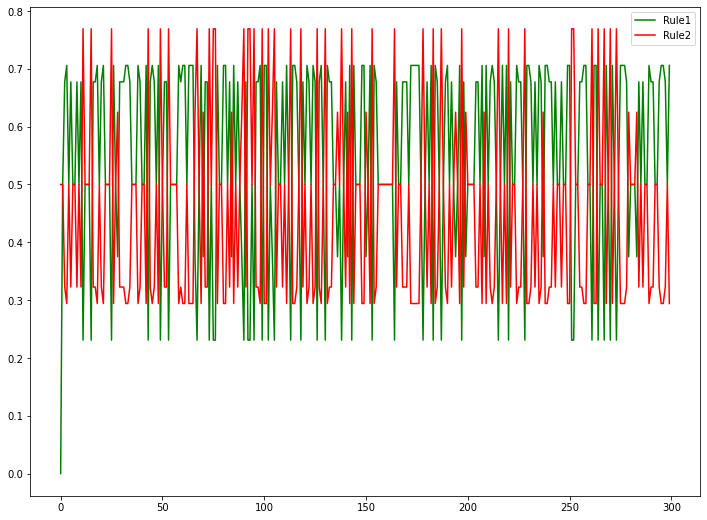

In [193]:
# posterior probability of states/rules
plt.figure(figsize=(12, 9))

plt.plot(likelihood[0][:], 'g')

plt.plot(likelihood[1][:], 'r')

plt.legend(['Rule1', 'Rule2'])

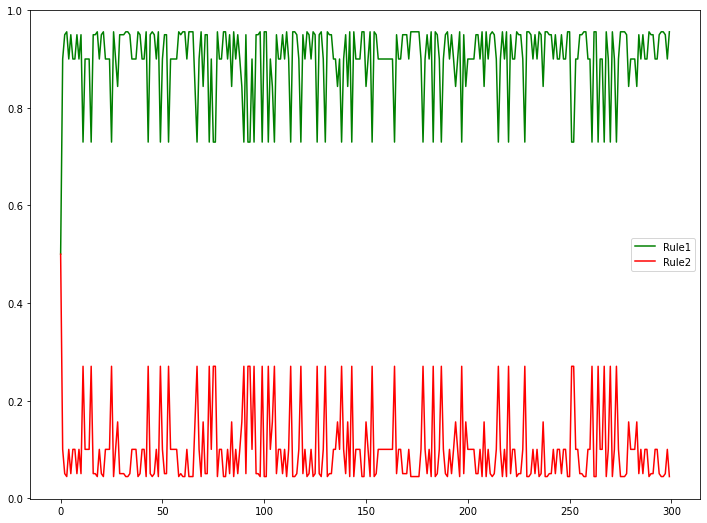

In [194]:
# posterior probability of states/rules
plt.figure(figsize=(12, 9))

plt.plot(gamma_probabilities[0][:], 'g')

plt.plot(gamma_probabilities[1][:], 'r')

plt.legend(['Rule1', 'Rule2'])